In [1]:
import os
os.chdir("../")

In [2]:
import warnings
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'font.sans-serif': ['Palatino', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "cm",
    # 'mathtext.rm': "asana math",
    # 'mathtext.cal': "asana math",
    "font.size": 16,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)


In [3]:
import re
import numpy as np
import pandas as pd


class DBSFileParser:

    def __init__(self, csv_path, max_height=250, bridge_align=40, time_interval=600, 
                 select_hour=[0,1,2]):
        df = pd.read_csv(csv_path, skiprows=1).dropna(how="any", inplace=False)
        df["Date_time"] = df["Date_time"].apply(lambda x: f"{x[:4]}-{x[4:6]}-{x[6:8]} {x[9:]}")
        df["Date_time"] = pd.to_datetime(df["Date_time"])
        # select data in specific hour

        df = df[df["Date_time"].dt.hour.isin(select_hour)]
        print(df.columns)
        heights = df.columns[7:]
        heights = [int(re.findall('([0-9]+)', height)[0])
                   for height in heights[::4]]
        heights = list(filter(lambda x: x <= max_height, heights))
        data_each_height = {height: df[df.columns[7:][4*i: 4*i+4]]
                            for i, height in enumerate(heights)}
        

        for height in heights:
            val = data_each_height[height].copy()

            val.columns = ["u", "beta", "db", "zwind"]
            val.loc[:, "time"] = df["Date_time"].values
            for i in range(4):
                val.index = range(val.shape[0])
                val.drop(
                    np.where(np.abs(val.iloc[:, i] - 999) < 1e-3)[0], inplace=True, axis=0)

            thetas = np.deg2rad(val["beta"].values - bridge_align)  # 桥轴向为0度
            val["ux"] = val["u"] * np.cos(thetas)
            val["uy"] = val["u"] * np.sin(thetas)
            data_each_height[height] = val

        self.data_each_height = data_each_height
        self.time_interval = time_interval

In [4]:
dbs_parser = DBSFileParser("data/20240707.csv", max_height=400, bridge_align=40, time_interval=600)
dbs_parser.data_each_height.keys()

Index(['Date_time', 'Temperature', 'Humidity', 'Pressure', 'Direction',
       'Azimuth', 'Pitch', '56m WindSpeed', '56m WindDirection', '56m SNR(dB)',
       ...
       '8528m SNR(dB)', '8528m ZWind', '8557m WindSpeed',
       '8557m WindDirection', '8557m SNR(dB)', '8557m ZWind',
       '8585m WindSpeed', '8585m WindDirection', '8585m SNR(dB)',
       '8585m ZWind'],
      dtype='object', length=1211)


dict_keys([56, 85, 113, 142, 170, 199, 227, 255, 284, 312, 341, 369, 398])

In [9]:
z = 113
df = dbs_parser.data_each_height[z]
u = df["u"].values
beta = df["beta"].values

In [10]:
target_dt = "2s"   # 3 秒间隔 -> 改为 "1S","100ms","1T"(1分钟) 等

# 转索引并按时间排序
df= df.copy()
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time').sort_index()

# 如果存在重复时间戳，先聚合（取平均）
df = df[~df.index.duplicated(keep='first')]  # 或者 df.groupby(level=0).mean()

# 重采样（采用 mean 作为聚合/占位），然后按时间插值填补缺失值
resampled = df.resample(target_dt).mean()
# 对数值列按时间插值（保留非数值列不变）
resampled = resampled.interpolate(method='time', limit_direction='both')

In [11]:

from scipy.signal import medfilt

ux = u * np.cos(np.deg2rad(beta))
uy = u * np.sin(np.deg2rad(beta))
u_bar = np.sqrt(np.mean(ux)**2 + np.mean(uy)**2)
beta_bar = np.rad2deg(np.arctan2(np.mean(uy), np.mean(ux)))
uu = ux * np.cos(beta_bar) + uy * np.sin(beta_bar) - u_bar
# uu = medfilt(uu, kernel_size=5) 


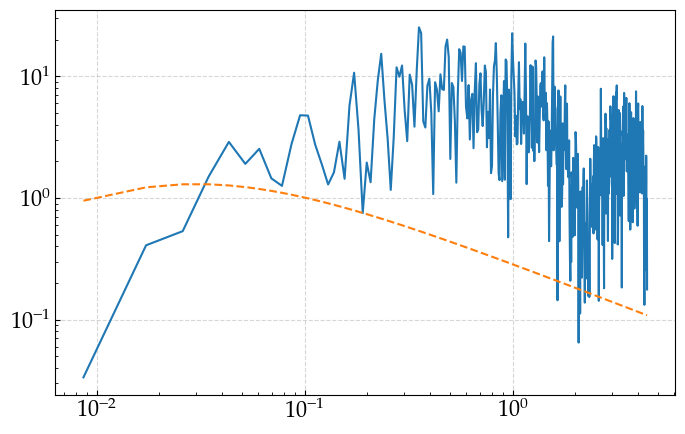

In [12]:
frequencies, psd = signal.welch(uu, fs=1/3, window='hamming', 
                                scaling='density', nperseg=1024)
frequencies = frequencies[1:]  # 去掉直流分量
psd = psd[1:]
z0 = 1.0
H_ = 10
K = 0.4
zd = H_ - z0 / K
u10 = u_bar / (z/10)**0.30
u_star = K * u_bar / np.log((z - zd) / z0)
f = frequencies * z / u_bar
reference_psd = 200 * f / (1 + 50 * f)**(5/3) * u_star**2 / frequencies

plt.figure(figsize=(8, 5))
plt.loglog(frequencies*z/u_bar, 
           psd*frequencies/(u_star**2),
           label=f"Height = 56 m")
plt.loglog(f, reference_psd*frequencies/(u_star**2), '--', label="Kaimal Spectrum")


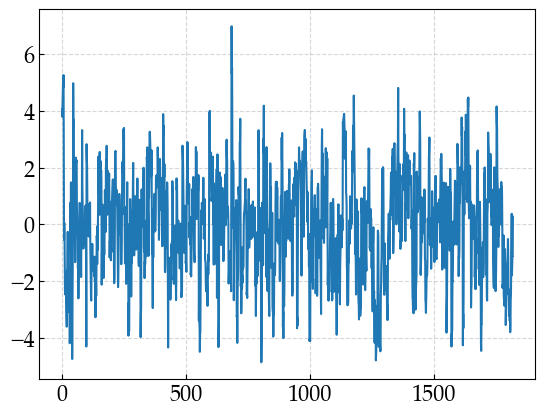

In [13]:
plt.plot(uu)